<a href="https://colab.research.google.com/github/vNexif/Captcha_AI/blob/main/Captcha_AI.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [14]:
!pip install astroid\
autopep8\
captcha\
certifi\
cffi\
colorama\
isort\
lazy-object-proxy\
mccabe\
mkl-fft\
mkl-random\
numpy\
olefile\
pandas\
Pillow\
pycodestyle\
pycparser\
pylint\
python-dateutil\
pytz\
six\
torch\
torchvision\
typed-ast\
wincertstore\
wrapt\
fastai===1.0.61

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [15]:
# Import fastai libraries
import json

from os.path import join

from fastai.vision import *
from fastai.callbacks import *
from fastai.callback import *
from fastai import *

from pathlib import Path

import os
import pandas as pd
from captcha.image import ImageCaptcha
from shutil import copyfile


from collections import defaultdict
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import models, transforms

from captcha.image import ImageCaptcha
from shutil import copyfile
from os.path import join
import numpy as np
import os
from collections import defaultdict
import pandas as pd


In [16]:
def log_train(epoch, trained_sample, total_sample, loss, correct, batch_size):
    '''
    A helper function to log the train result
    '''
    log = 'Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}, Accuracy: {}/{} ({:.0f}%)'.format(
        epoch,
        trained_sample,
        total_sample,
        100. * trained_sample / total_sample,
        loss,
        correct,
        batch_size,
        100. * correct / batch_size
    )
    print(log)


def log_test(loss, correct, test_size):
    '''
    A helper function to log the test result
    '''
    log = 'Test set: Average loss: {:.6f}, Accuracy: {}/{} ({:.0f}%)'.format(
        loss, correct, test_size, 100. * correct / test_size)
    print(log)


def train(log_interval, model, device, train_loader, 
          optimizer, epoch, target_transform, 
          folder, model_file_path, criterion=None,
          train_history=None):
    # set model to train mode
    model.train()
    for batch_idx, (data, target) in enumerate(train_loader):
        target = target_transform(target, folder)
        data, target = data.to(device), target.to(device)
        optimizer.zero_grad()
        output = model(data)

        # Set to BCEWithLogitsLoss it criterion is not provided
        if criterion is None:
            criterion = torch.nn.BCEWithLogitsLoss()
        loss = criterion(output, target)
        loss.backward()
        optimizer.step()
        preds = get_preds_from_output(output)
        true_val = get_preds_from_output(target)

        correct = (preds == true_val).sum()

        if train_history is not None:
            train_history.accmulate_train_history(loss.item(), correct, len(data))
        
        if batch_idx % log_interval == 0:
            log_train(epoch, batch_idx * len(data),
                      len(train_loader.dataset), loss.item(), correct, len(data))
        
            torch.save(model.state_dict(), model_file_path)


def test(model, device, test_loader, target_transform,
         folder, criterion=None, train_history=None):
    # set model to eval mode
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for batch_idx, (data, target) in enumerate(test_loader):
            o_target = target
            target = target_transform(target, folder)
            data, target = data.to(device), target.to(device)
            output = model(data)

            # Set to BCEWithLogitsLoss it criterion is not provided
            if criterion is None:
                criterion = torch.nn.BCEWithLogitsLoss()
            test_loss = criterion(output, target).item()
            preds = get_preds_from_output(output)
            true_val = get_preds_from_output(target)
            correct = (preds == true_val).sum()
            if train_history is not None:
                train_history.accmulate_test_history(
                    test_loss, correct, len(data))
            log_test(test_loss, correct, len(data))


def get_target_from_indices(idxes, folder):
    '''
    Transform the indices, which are generated by the ImageFolder object by defualt
    to torch tensor of shape (batch size, number of unique characters * length of captcha)
    For example, if the length of captcha is 2 and the captcha only consists of digits(0-9),
    the captcha target "82" will be transformed to
        [
            0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 
            0, 0, 1, 0, 0, 0, 0, 0, 0, 0
        ]

    Args:
        idxes (torch.tensor): a tensor with indexes corresponding
            to each folder of the image directory
        folder (ImageFolder): an ImageFolder object that contains information of the classes
    
    Returns:
        torch.tensor: a torch tensor with the multilabel targets encoded
    '''
    characters_length = len(CHARACTERS)
    result_tensor = torch.zeros((len(idxes), characters_length * CAP_LEN))

    def set_kth_tensor(k, c, i):
        position = CHARACTERS.find(c)
        result_tensor[i][characters_length * k + position] = 1

    def set_ith_idx(i, idx):
        cap_str = folder.classes[idx]
        [set_kth_tensor(k, c, i) for k, c in enumerate(cap_str)]

    [set_ith_idx(i, idx) for i, idx in enumerate(idxes)]
    return result_tensor


def get_preds_from_output(output):
    '''
    Get preditions from the output tensor by the model

    Args:
        output (torch.tensor): A torch tensor of size (batch size,
            number of unique characters * length of captcha)

    Returns:
        np.arrays: A numpy array of length equal to batch size, with
            each element equal to the corresponding prediction in string

    '''
    characters_length = len(CHARACTERS)
    preds = [""] * len(output)
    for i in range(CAP_LEN):
        idx_arr = output[:, i *
                         characters_length:(i+1) * characters_length].argmax(dim=1)
        for k, pred in enumerate(idx_arr):
            preds[k] += CHARACTERS[pred.item()]
    return np.array(preds)


def get_transformation(img_width=None, img_height=None):
    '''
    A function to perform a sequence of transformations to the input image
    
    Args:
        img_width (int): desired image width after resize
        img_height (int): desired image height after resize

    Returns:
        torchvision.transforms.Compose
    '''
    transform_list = [] if img_width is None else [
        transforms.Resize((img_height, img_width))]
    transform_list.extend([transforms.ToTensor(),
                           transforms.Normalize((0.8760, 0.8800, 0.8783),
                                                (0.1692, 0.1523, 0.1683))])
    return transforms.Compose(transform_list)


In [17]:
# Const for captcha generation
from os.path import join
DES_PATH = "."
RESULT_FILE_NAME = 'captcha_img'

CHARACTERS = '0123456789ABCDEFGHIJKLMNOPQRSTUVWXYZ'
CAP_LEN = 4

NO_TRAIN_CAP = 100000
NO_TEST_CAP = 10000

# Config for model training
TRAIN_DIR = join(DES_PATH, RESULT_FILE_NAME)
TEST_DIR = join(DES_PATH, RESULT_FILE_NAME)
OUT_FILENAME = join(RESULT_FILE_NAME, 'labels.csv')

EPOCHS = 2
LOG_INTERVAL = 10
SEED = 1
LR = 1e-3
BATCH_SIZE = 128


In [18]:
# Generate 100000 images for the AI to learn on
def gen_str(size, characters):
    while True:
        positions = np.random.randint(len(characters), size=size)
        yield ''.join(map(lambda x: characters[x], positions))


def generate_captcha(captcha, out_dir, no_of_img=10000, size=CAP_LEN, characters=CHARACTERS):
    if not os.path.isdir(out_dir):
        os.makedirs(out_dir)

    str_gen = gen_str(size, characters)    

    img_dict = defaultdict(int)
    for i in range(no_of_img):
        text = next(str_gen)
        if i % 10000 == 0:
            print("Generating image {} of {}".format(i, no_of_img))
        img_name = f'{text}_{img_dict[text]}.png'
        img_dict[text] += 1
        captcha.write(text, join(out_dir, img_name))
    return True


def generate_feather(train_dir, valid_dir, out_filename):
    def process_filename(filename):
        text = filename.split('_')[0]
        return list(map(lambda x: f'{x[1]}{x[0]}', enumerate(text)))


    rows = []
    for filename in os.listdir(train_dir):
        rows.append((os.path.join('train', filename),
                    process_filename(filename), False))

    for filename in os.listdir(valid_dir):
        rows.append((os.path.join('valid', filename),
                    process_filename(filename), True))

    df = pd.DataFrame(rows, columns=['name', 'label', 'is_valid'])
    df.to_feather(out_filename, index=False)



def main():
    ic = ImageCaptcha()

    train_dir = join(DES_PATH, RESULT_FILE_NAME, 'train')
    valid_dir = join(DES_PATH, RESULT_FILE_NAME, 'valid')

    directories = [train_dir, valid_dir]
    nos_of_img = [NO_TRAIN_CAP, NO_TEST_CAP]

    for directory, no_of_img in zip(directories, nos_of_img):
        generate_captcha(captcha=ic, out_dir=directory,
                         no_of_img=no_of_img, size=CAP_LEN, characters=CHARACTERS)
    

if __name__ == "__main__":
    main()


Generating image 0 of 100000
Generating image 10000 of 100000
Generating image 20000 of 100000
Generating image 30000 of 100000
Generating image 40000 of 100000
Generating image 50000 of 100000
Generating image 60000 of 100000
Generating image 70000 of 100000
Generating image 80000 of 100000
Generating image 90000 of 100000
Generating image 0 of 10000


In [19]:
# Get all the inputs and targets from image files and save it to labels

def process_filename(filename):
    text = filename.split('_')[0]
    return list(map(lambda x: f'{x[1]}{x[0]}', enumerate(text)))

path = Path('captcha_img')
rows = []
for filename in os.listdir(path/'train'):
    if not filename.endswith('png'):
        continue
    rows.append((os.path.join('train', filename), process_filename(filename), False))

for filename in os.listdir(path/'valid'):
    if not filename.endswith('png'):
        continue
    rows.append((os.path.join('valid', filename), process_filename(filename), True))
    
df = pd.DataFrame(rows, columns=['name', 'label', 'is_valid'])

df.head()

name             label  is_valid
0  train/YMYU_0.png  [Y0, M1, Y2, U3]     False
1  train/FSW8_0.png  [F0, S1, W2, 83]     False
2  train/FZQA_0.png  [F0, Z1, Q2, A3]     False
3  train/OB31_0.png  [O0, B1, 32, 13]     False
4  train/DC5Y_0.png  [D0, C1, 52, Y3]     False

In [20]:
# Create a databunch object for the fastai learner
path = Path('captcha_img')
il = ImageList.from_df(df, path).split_from_df().label_from_df()
data = il.databunch()

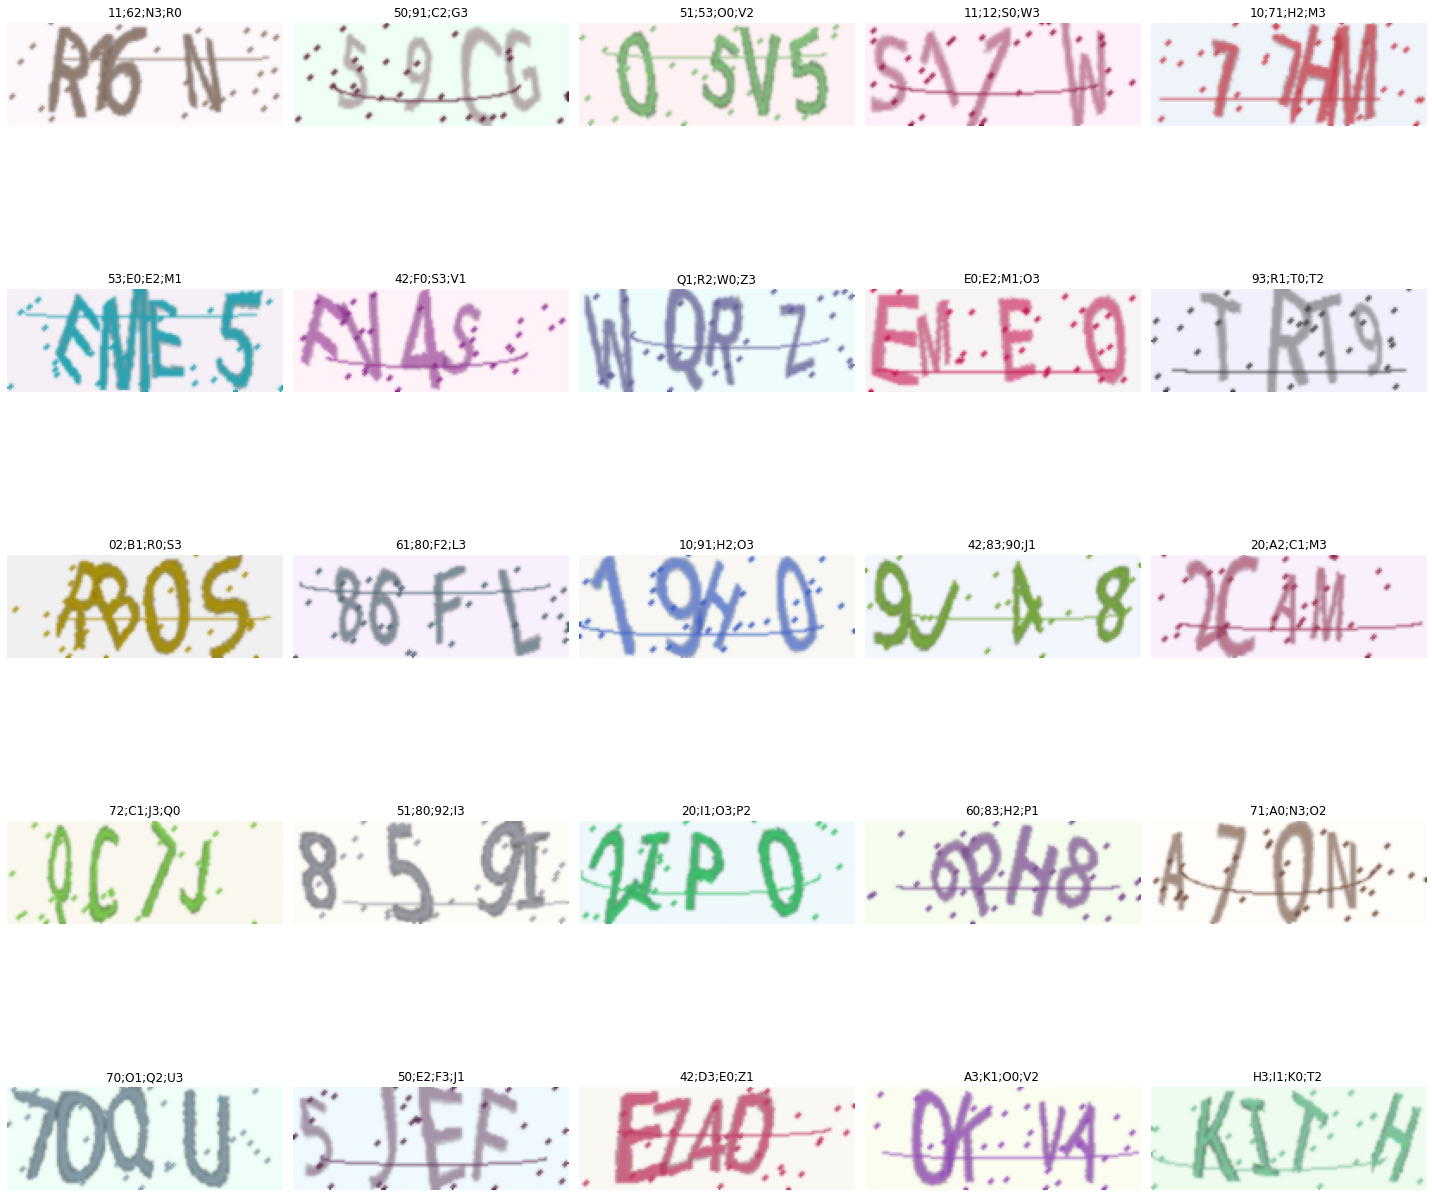

In [21]:
data.show_batch()

In [22]:
def captcha_accuracy(y_pred, y_true, get_mean=True):
    sorted_pred, _ = y_pred.sort(1)
    y_pred = y_pred >= sorted_pred[:, -4].float().view((-1, 1))
    y_true = y_true.byte()
    
    result = (((y_pred == y_true) & (y_true == 1)).float().sum(1) / 4.)
    if get_mean == True:
        result = result.mean()
    return result


In [23]:
learn = cnn_learner(data, models.resnet50,metrics=captcha_accuracy, pretrained=False)

/usr/local/lib/python3.7/dist-packages/torchvision/models/_utils.py:136: UserWarning: Using 'weights' as positional parameter(s) is deprecated since 0.13 and will be removed in 0.15. Please use keyword parameter(s) instead.
  f"Using {sequence_to_str(tuple(keyword_only_kwargs.keys()), separate_last='and ')} as positional "
/usr/local/lib/python3.7/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


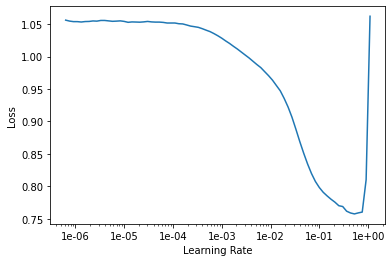

In [24]:
learn.lr_find()
learn.recorder.plot(skip_end=5)

In [25]:
learn.fit_one_cycle(2, max_lr=slice(3e-3,2e-2))

In [26]:
learn.save('res-default')

In [27]:
def get_preds_with_top_loss_idx(learn):
    y_pred, y_true, losses = learn.get_preds(with_loss=True)
    acc = captcha_accuracy(y_pred, y_true, get_mean=False)
    sorted_pred, _ = y_pred.sort(1)
    losses = losses.view((-1, 144)).mean(1)    
    top_loss_idx = losses.argsort(descending=True)
    
    y_pred = y_pred >= sorted_pred[:, -4].float().view((-1, 1))
    return y_pred, y_true, losses, top_loss_idx, acc

def show_top_losses(learn, row=3):
    y_pred, y_true, losses, top_loss_idx, acc = get_preds_with_top_loss_idx(learn)
    axs = subplots(row, row, figsize=(20, 10), title='index / pred / true / loss / accuracy').reshape(-1)
    y_recon = data.valid_ds.y.reconstruct
    for idx, ax in zip(top_loss_idx[:row*row], axs):
        title = f"{idx} / {y_recon(y_pred[idx])} / {y_recon(y_true[idx])} / {losses[idx]:0.3f} / {acc[idx]:0.2f}"
        ax = show_image(data.valid_ds[idx][0], ax=ax)
        ax.set_title(title)

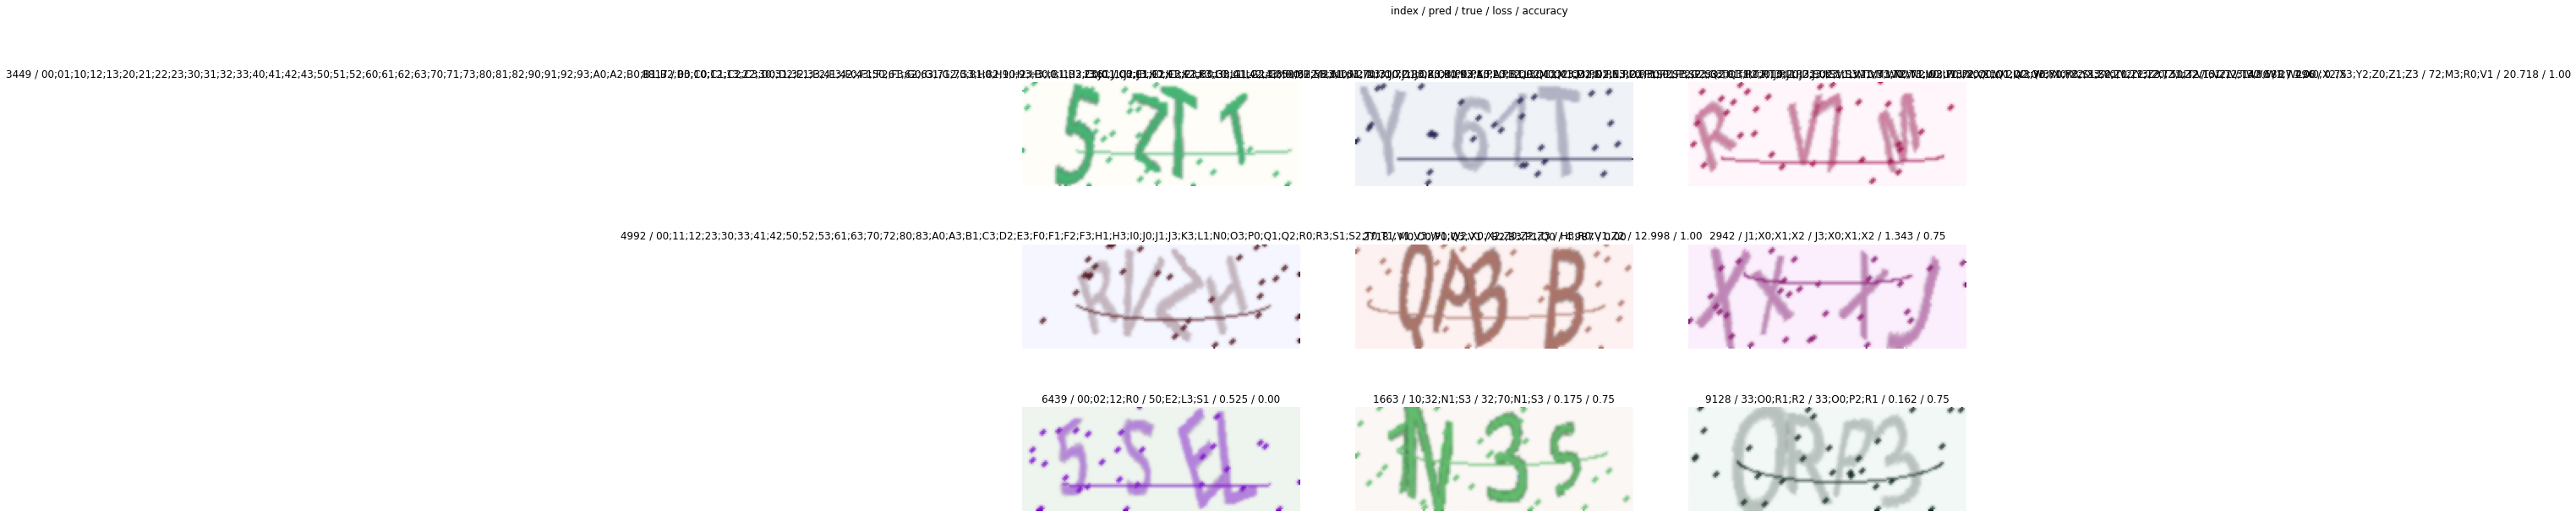

In [28]:
show_top_losses(learn)

In [29]:
learn2 = cnn_learner(data, models.resnet50,metrics=captcha_accuracy, pretrained=False, wd=0.05, ps=0.2)

/usr/local/lib/python3.7/dist-packages/torchvision/models/_utils.py:136: UserWarning: Using 'weights' as positional parameter(s) is deprecated since 0.13 and will be removed in 0.15. Please use keyword parameter(s) instead.
  f"Using {sequence_to_str(tuple(keyword_only_kwargs.keys()), separate_last='and ')} as positional "
/usr/local/lib/python3.7/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


In [30]:
learn2.fit_one_cycle(2, max_lr=slice(3e-3,2e-2))

In [31]:
learn2.save('res-0.05-0.2')

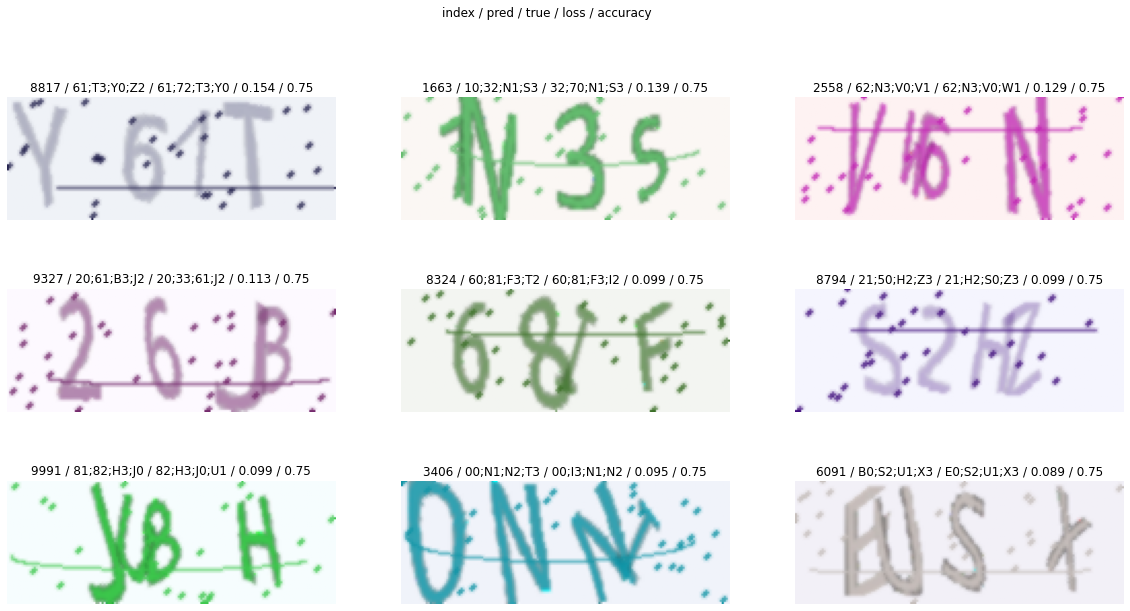

In [32]:
show_top_losses(learn2)

In [33]:
learn3 = cnn_learner(data, models.resnet50,metrics=captcha_accuracy, pretrained=False, wd=0.02, ps=0.2)
learn3.fit_one_cycle(2, max_lr=slice(3e-3,2e-2))

/usr/local/lib/python3.7/dist-packages/torchvision/models/_utils.py:136: UserWarning: Using 'weights' as positional parameter(s) is deprecated since 0.13 and will be removed in 0.15. Please use keyword parameter(s) instead.
  f"Using {sequence_to_str(tuple(keyword_only_kwargs.keys()), separate_last='and ')} as positional "
/usr/local/lib/python3.7/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


In [34]:
learn3.save('res-0.02-0.2')

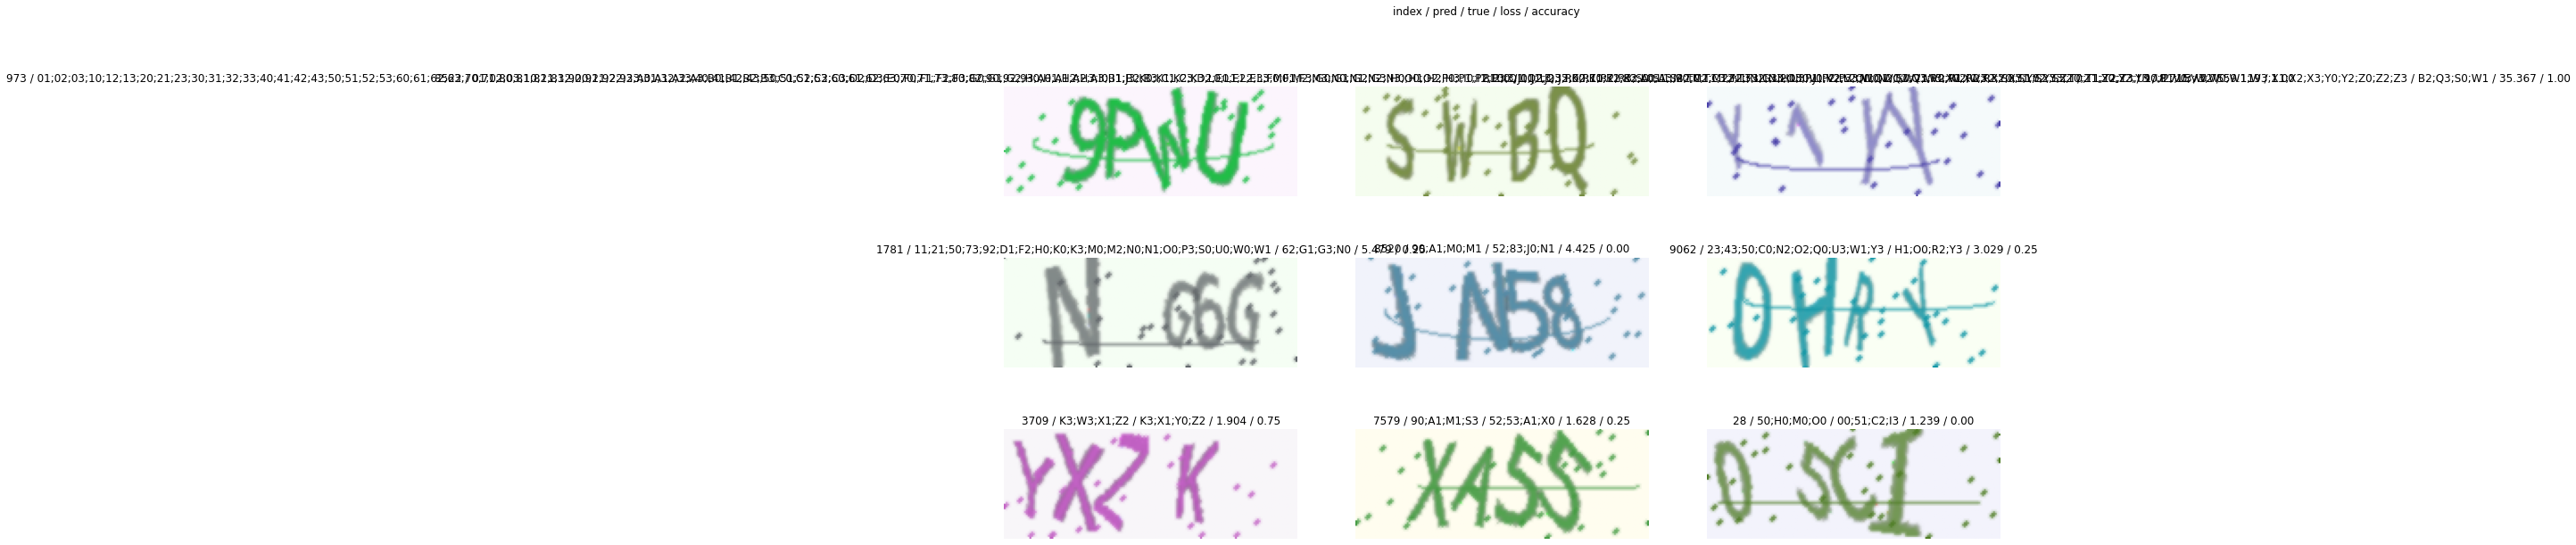

In [35]:
show_top_losses(learn3)

In [36]:
learn4 = cnn_learner(data, models.resnet50,metrics=captcha_accuracy, pretrained=False, wd=0.01, ps=0.2)
learn4.fit_one_cycle(2, max_lr=slice(3e-3,2e-2))

/usr/local/lib/python3.7/dist-packages/torchvision/models/_utils.py:136: UserWarning: Using 'weights' as positional parameter(s) is deprecated since 0.13 and will be removed in 0.15. Please use keyword parameter(s) instead.
  f"Using {sequence_to_str(tuple(keyword_only_kwargs.keys()), separate_last='and ')} as positional "
/usr/local/lib/python3.7/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


In [37]:
learn4.save('res-0.01-0.2')

In [38]:
learn5 = cnn_learner(data, models.resnet50,metrics=captcha_accuracy, pretrained=False, wd=0.01, ps=0.1)
learn5.fit_one_cycle(2, max_lr=slice(3e-3,2e-2))

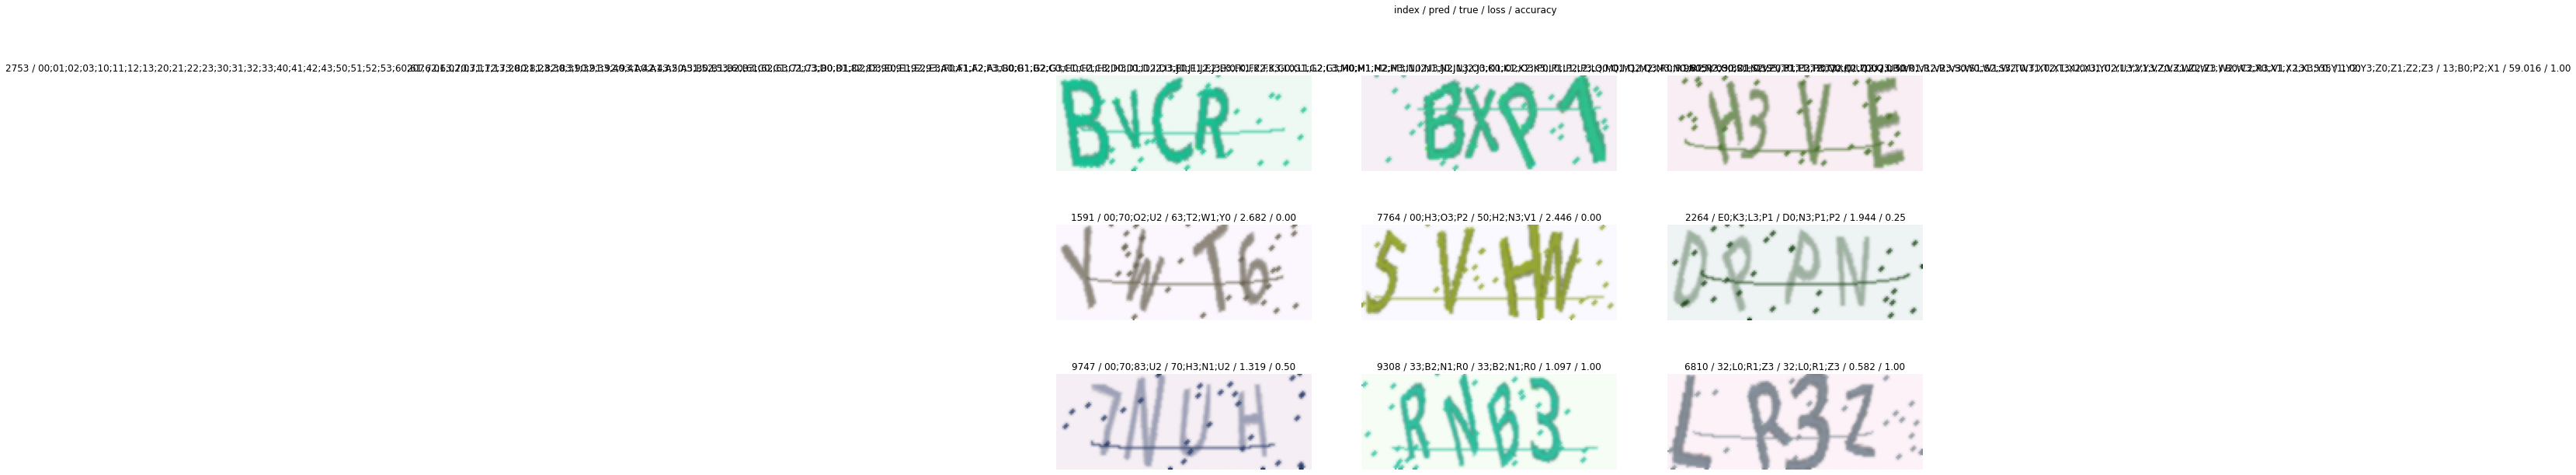

In [39]:
show_top_losses(learn5)

In [40]:
learn5.save('res-0.01-0.1')

In [41]:
learn2.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


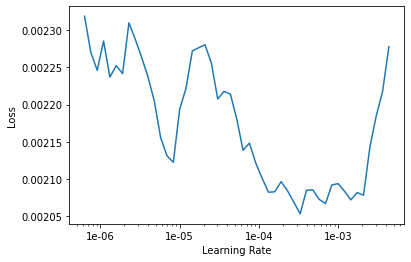

In [42]:
learn2.recorder.plot(skip_end=10)

In [43]:
learn2.fit_one_cycle(1, max_lr=slice(1e-6,5e-5))

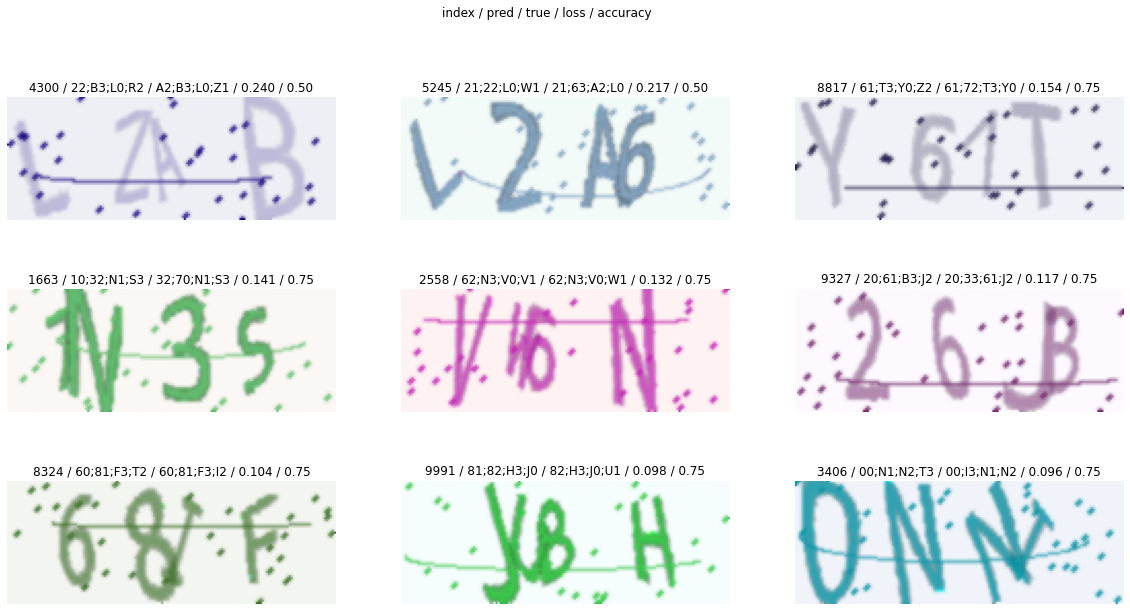

In [44]:
show_top_losses(learn2)

In [45]:
learn2.save('res-0.05-0.2-stage2')

In [46]:
learn2 = learn2.load('res-0.05-0.2-stage2')

In [47]:
def hooked_backward(learn, xb, layer_idx):
    m = learn.model.eval()
    with hook_output(m[0][layer_idx]) as hook_a:
            preds = m(xb)
    return hook_a


def show_heatmap(hm, x_im, item_idx, layer_idx, ax):
    x_im.show(ax, title=f'layer {layer_idx}, item {item_idx}')
    ax.imshow(hm, alpha=0.6, extent=(0,160, 60,0),
              interpolation='bilinear', cmap='magma');

def visualize_layer_of_item(learn, item_idxes, layer_idxes, row=2):
    data = learn.data
    axes = subplots(row, row, figsize=(20, 10)).reshape(-1)
    for item_idx, layer_idx, ax in zip(item_idxes, layer_idxes, axes):
        x,y = data.valid_ds[item_idx]
        xb, _ = data.one_item(x)

        hook_a = hooked_backward(learn, xb.cuda(), layer_idx)
        acts  = hook_a.stored[0].cpu()
        avg_acts = acts.mean(0)

        show_heatmap(avg_acts, x, item_idx, layer_idx, ax)

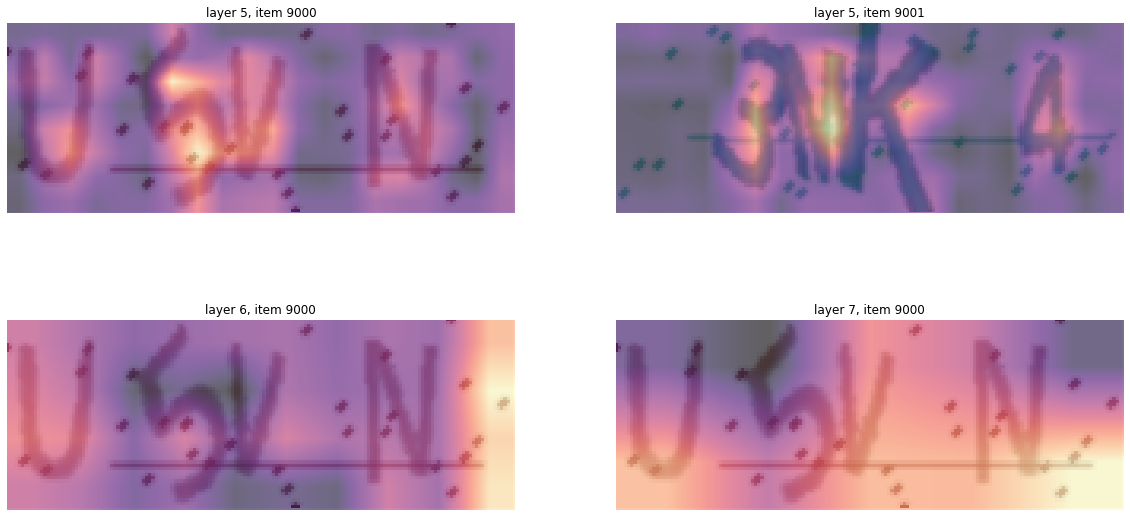

In [48]:
visualize_layer_of_item(learn2, [9000, 9001, 9000, 9000], [5, 5, 6, 7])

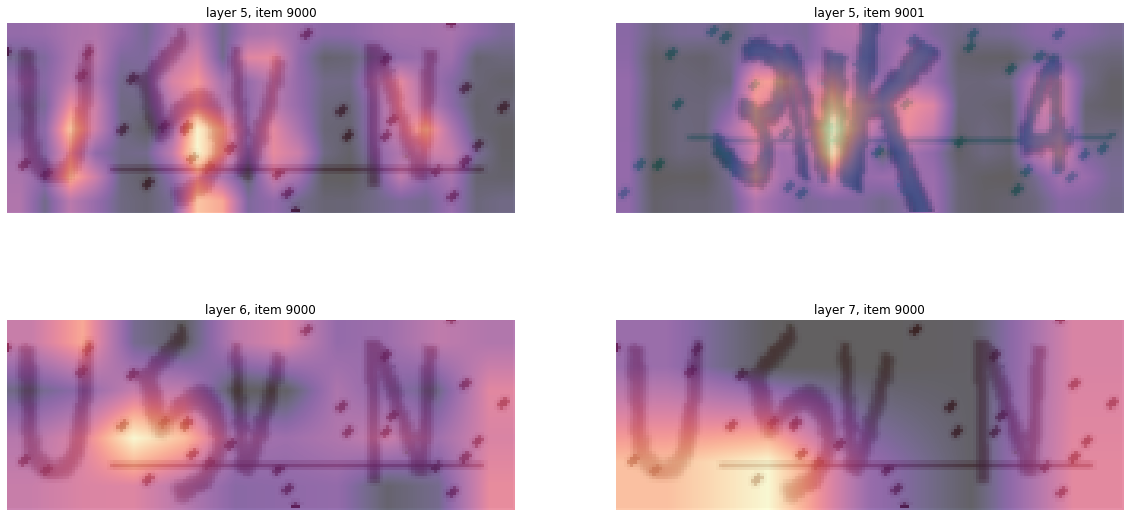

In [49]:
visualize_layer_of_item(learn3, [9000, 9001, 9000, 9000], [5, 5, 6, 7])

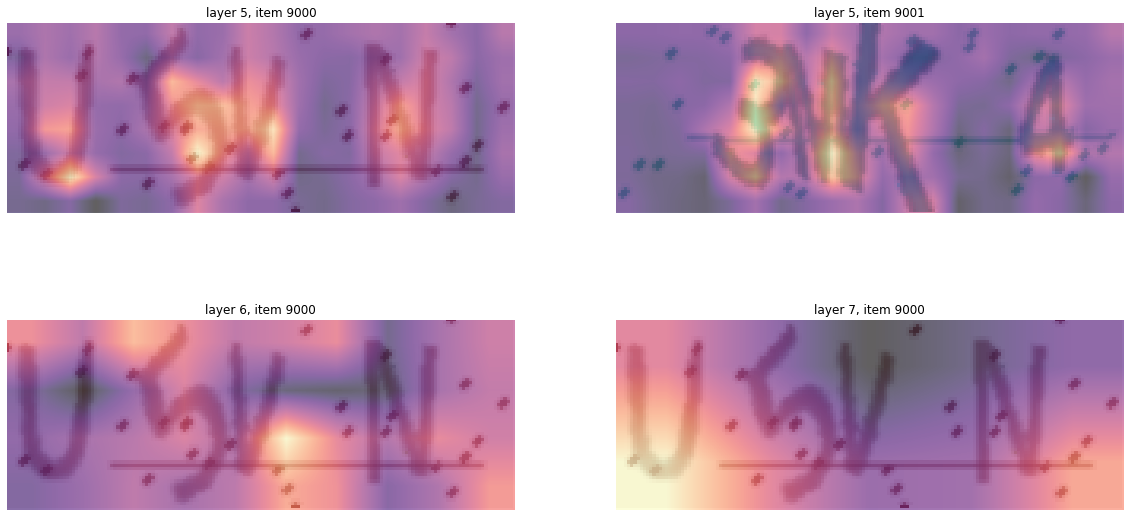

In [50]:
visualize_layer_of_item(learn4, [9000, 9001, 9000, 9000], [5, 5, 6, 7])